In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
path = input("Enter video name with path: ")

Enter video name with path: v1.mp4


In [4]:
cap = cv2.VideoCapture(path)

In [5]:
frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frames)

188


In [6]:
#Reading the first frame
ret, firstFrame = cap.read()

prevGray = cv2.cvtColor(firstFrame, cv2.COLOR_BGR2GRAY)
transform = np.zeros((frames-1, 3), np.float32)

In [7]:
for i in range(frames-1):
    p0 = cv2.goodFeaturesToTrack(prevGray, maxCorners=200, qualityLevel=0.01, minDistance=30, blockSize=3)

    ret, currFrame = cap.read()
    if not ret:
        break

    currGray = cv2.cvtColor(currFrame, cv2.COLOR_BGR2GRAY)

    #Tracking the points
    p1, found, err = cv2.calcOpticalFlowPyrLK(prevGray, currGray, p0, None)
    
    idx = np.where(found==1)
    p0 = p0[idx]
    p1 = p1[idx]

    #Rigid transformation
    rigidT = cv2.estimateAffinePartial2D(p0, p1)[0]
    '''[cos(ang) -sin(ang)  x
        sin(ang)  cos(ang)  y]'''
    
    x = rigidT[0, 2]
    y = rigidT[1, 2]
    angle = np.arctan2(rigidT[1, 0], rigidT[0, 0])

    transform[i] = [x, y, angle]

    prevGray = currGray

In [8]:
#Cumulative sum of transform for x, y and angle
trajectory = np.cumsum(transform, axis=0)
print(trajectory.shape)

(187, 3)


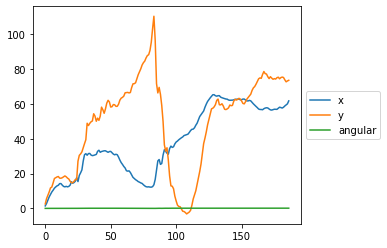

In [9]:
fig = plt.figure()
ax = plt.subplot(111)

plt.plot(trajectory[:, 0], label='x')
plt.plot(trajectory[:, 1], label='y')
plt.plot(trajectory[:, 2], label='angular')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Moving Average Filter
A moving average can help an analyst filter noise and create a smooth curve from an otherwise noisy curve. The most commonly used Moving Averages(MAs) are the **Simple**, **Cumulative** and **Exponential** moving average.
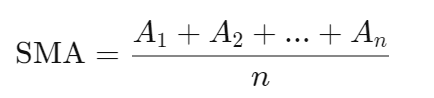

In [10]:
df = pd.DataFrame(transform, columns=['x', 'y', 'ang'])

In [11]:
#Simple Moving Average
df['x_MA'] = df.x.rolling(4, min_periods=1).mean()
df['y_MA'] = df.y.rolling(4, min_periods=1).mean()
df['ang_MA'] = df.ang.rolling(4, min_periods=1).mean()

df.head()

,x,y,ang,x_MA,y_MA,ang_MA
0,1.419766,2.546835,-0.001123,1.419766,2.546835,-0.001123
1,1.424924,3.068868,-0.001414,1.422345,2.807852,-0.001269
2,1.808135,1.842231,0.003347,1.550942,2.485978,0.000270
3,1.942489,1.974924,0.003565,1.648828,2.358215,0.001094
4,1.435913,2.320521,0.000972,1.652865,2.301636,0.001618


In [12]:
transform1 = df.to_numpy()

#Cumulative sum of original & MAs values
trajectory1 = np.cumsum(transform1, axis=0)

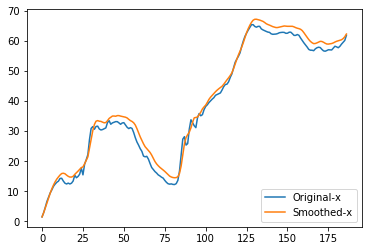

In [13]:
#x original&MA
plt.plot(trajectory1[:, 0], label='Original-x')
plt.plot(trajectory1[:, 3], label='Smoothed-x')
plt.legend(loc='lower right')

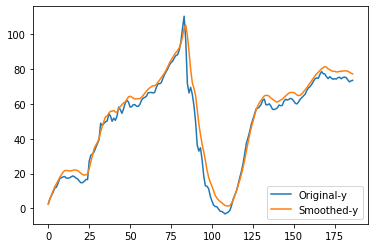

In [14]:
#y original&MA
plt.plot(trajectory1[:, 1], label='Original-y')
plt.plot(trajectory1[:, 4], label='Smoothed-y')
plt.legend(loc='lower right')

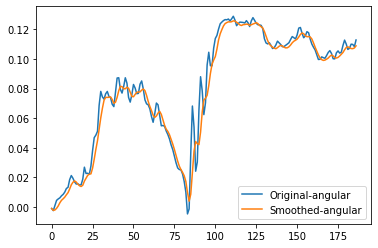

In [15]:
#ang original&MA
plt.plot(trajectory1[:, 2], label='Original-angular')
plt.plot(trajectory1[:, 5], label='Smoothed-angular')
plt.legend(loc='lower right')

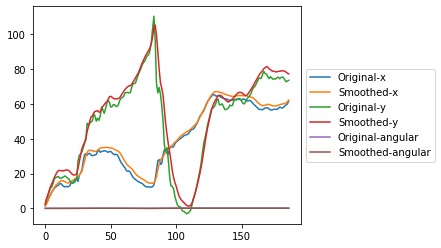

In [16]:
fig = plt.figure()
ax = plt.subplot(111)

plt.plot(trajectory1[:, 0], label='Original-x')
plt.plot(trajectory1[:, 3], label='Smoothed-x')
plt.plot(trajectory1[:, 1], label='Original-y')
plt.plot(trajectory1[:, 4], label='Smoothed-y')
plt.plot(trajectory1[:, 2], label='Original-angular')
plt.plot(trajectory1[:, 5], label='Smoothed-angular')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [17]:
diff = trajectory1[:, 3:6]-trajectory
FTransform = transform+diff

#Resetting video to 1st frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [18]:
for i in range(frames-1):
    ret1, Frame = cap.read()
    if not ret1:
        break

    #Smoothed values of x, y and angle
    x = FTransform[i, 0]
    y = FTransform[i, 1]
    angle = FTransform[i, 2]

    #Smoothed transformation values matrix
    Final_rigidT = np.ones((2, 3), np.float32)
    Final_rigidT[0, 0] = np.cos(angle)
    Final_rigidT[0, 1] = -np.sin(angle)
    Final_rigidT[1, 0] = np.sin(angle)
    Final_rigidT[1, 1] = np.cos(angle)
    Final_rigidT[0, 2] = x
    Final_rigidT[1, 2] = y
    '''[cos(ang) -sin(ang)  x
        sin(ang)  cos(ang)  y]'''

    #Applying smoothed transform to the input frame
    finalFrame = cv2.warpAffine(Frame, Final_rigidT, (w, h))

    cv2.imshow("Input video", Frame)
    #Stabilized output
    cv2.imshow("Output video", finalFrame)

    if cv2.waitKey(50) == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()